Assume that sand is dispensed at the beginning of the conveyor belt. 
Sand is poured into a funnel from another process from above, and falls through the funnel onto the beginning of the conveyor belt to be transported and subsequently processed. Assume that the lower end of the funnel measures 15cm in diamter.
$$
S(x,t) =
\begin{cases}
0.02 & \text{if } 0<x\leq 0.15 \\
0  & \text{otherwise}
\end{cases}
$$

In order to solve the realistic version of the advection-diffusion equation, we discretize the height of the sand-pile $h(x,t)$ and the sand source $s(x,t)$ with $N$ spatial gridpoints in $[0,L]$ (each of size $\Delta x$), where $L$ is the length of the conveyor and $M$ temporal gridpoints in $[0,T]$ (each of size $\Delta t$), where $T$ is the time necessary for the conveyor belt to complete one full cycle given constant belt velocity $v$.

Let $Ax=b$ be the tri-diagonal system representing this numerical approximation of the realistic advection-diffusion equation. 
$H^n_m$ represents the height of the sand-pile on the conveyor belt at discretized position $0\geq x\leq L$. Using a centered difference approximation and backward Euler's method, we obtain:

$$
-C H^{n+1}_{m+1} + (1 + 2C + U)H^{n+1}_m - (C+U)H^{n+1}_{m-1} = H^n_m + \Delta t S^{n+1}_m
$$

Which leads to the system $Ax=b$ where $A$ is the tri-diagonal matrix with diagonals entries given by the coefficients on the LHS of equation (1).
Next, we modify $A$ to impose a Dirichlet boundary condition at the beginning of the conveyor belt: $H^n_0=0$.
Lastly, we impose a robin boundary condition at the end of the conveyor belt: $D \partial_x H(L,t) + \alpha H(L,t) = \beta$, which leads to the following backward Euler scheme at the rightmost endpoint $(x=L)$:
$$
H^n + S^n\Delta t + \frac{2\beta C\Delta x}{D} =\left(1+2C+U-\frac{2\alpha C \Delta x}{D}\right)H_L^{n+1} - (2C + U)H_{L-1}^{n+1}
$$


<span style="color:red">If $\alpha=v$ then the robin BC is reflective. $0< \alpha < v$ for semi-permeable boundary </span>

In [8]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.sparse        import diags_array
from scipy.sparse.linalg import spsolve
import pandas as pd

In [9]:
def plotting(U,x,t, disp_times, exact_handle = None):
    # Set some markers and colours to make comparison easy
    markers = ['x','s','d','+','o','.']
    colours = ['xkcd:salmon','xkcd:golden rod','xkcd:teal','xkcd:purple','xkcd:slate','xkcd:silver']    
    
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    if(exact_handle != None):
        for i, idx_t in enumerate(disp_times):
            label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < T) else 't = {0:.0f}'.format(t[idx_t])
            ax.plot(x, exact_handle(x,t[idx_t]), color = colours[i], label = label)

    for i, idx_t in enumerate(disp_times):
        label = 't = {0:.0e}'.format(t[idx_t]) if (0 < t[idx_t] < T) else 't = {0:.0f}'.format(t[idx_t])
        ax.plot(x[::2], U[idx_t][::2], linestyle = '', marker = markers[i], color = colours[i], label = label )

    ax.legend(ncols = 2, loc = 'center',  bbox_to_anchor=(1.2, 0.5))
    ax.set_xlim(0-1e-2,11.0+1e-2)    # zoom in on area of interest with a bit of leeway each end
    plt.xlabel("Space (x)")
    plt.ylabel("Solution")
    plt.show()

In [10]:
L= 10.0 # 10m convyer belt, longest possible
v= 0.375 # advection velocity, mid point of suggested speeds
D= 0.03 # diffusion coefficient, small spreading of sand
alpha = v # Robin coefficient 
beta=0.1
s = 10 # source term, cont. rate of sand being added
s_start = 0.0
s_end = 0.15

Nx = 200; Nt = 1000
T = math.ceil(L/v) # one conveyor belt loop 

x = np.linspace(0, L, Nx+1)
dx = x[1] - x[0] # grid spacing for finite differences

t = np.linspace(0, T, Nt+1)
dt = t[1] - t[0]

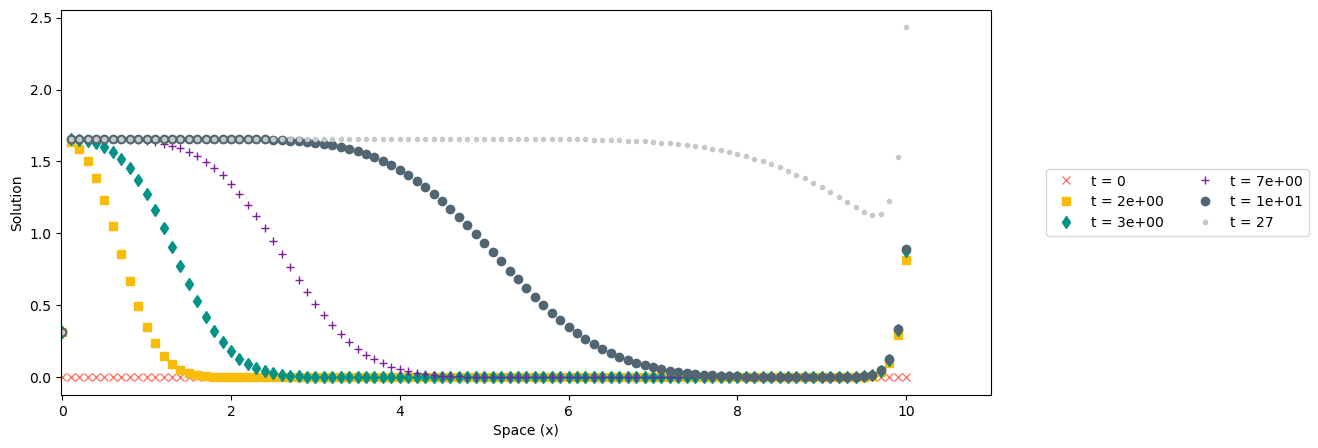

In [11]:
C = (D*dt)/(dx**2)
U = (v*dt)/dx

lower = (-1) * (C + U) * np.ones(Nx+1)
main  = (1 + 2*C + U) * np.ones(Nx+1)
upper = -C * np.ones(Nx+1)

upper[0] = 0
lower[-1] = (-2*C) - U 
main[-1] = 1 + (2*C) + U - 2*C*(alpha*dx/D)

A = diags_array([lower, main, upper], offsets=(-1, 0, 1), shape=(Nx+1, Nx+1), format='csr')

H = np.zeros((Nt+1,Nx+1))
S = np.zeros((Nt+1,Nx+1))

for i in range(Nx+1):
    delta = i*dx
    if(s_start <= delta and delta <= s_end):
        S[:,i] = s

for n in range(0, Nt):
    b = H[n] + S[n]*dt
    b[-1] += ((2*beta*C*dx)/D)
    
    H[n+1] = spsolve(A, b)

disp_times = [0, Nt//16, Nt//8, Nt//4, Nt//2, Nt]
plotting(H,x,t, disp_times)

In [12]:
def hL_analytic_robin(L, v, D, S, alpha):
    beta = v / D
    denom = (beta - alpha) * np.exp(beta * L) + alpha
    A = (S / v) * (alpha * L - 1.0) / denom
    return A * (np.exp(beta * L) - 1.0) + (S / v) * L

def hL_numeric_if_available(L, v, D, S, alpha, N=300):
    fn = globals().get("solve_central_robin_simple", None)
    if fn is None:
        # try the ghost-node version name if you used that
        fn = globals().get("solve_central_robin", None)
    if fn is None:
        return None  # not available -> caller will use analytic fallback
    x, h = fn(L, v, D, S, alpha, N)
    return h[-1]


def hL(L, v, D, S, alpha, N=300):
    h_num = hL_numeric_if_available(L, v, D, S, alpha, N=N)
    if h_num is not None:
        return float(h_num)
    return float(hL_analytic_robin(L, v, D, S, alpha))

def recommend_table(S, D, alpha, Hstar=1.0,
                    v_range=(0.25, 0.5), L_range=(5.0, 10.0),
                    v_steps=6, L_steps=6, N=300):
    vs = np.linspace(v_range[0], v_range[1], v_steps)
    Ls = np.linspace(L_range[0], L_range[1], L_steps)
    rows = []
    for L in Ls:
        for v in vs:
            hmax = hL(L, v, D, S, alpha, N=N)
            ok = (hmax <= Hstar)
            v_min_thumb = (S * L) / Hstar
            S_max_thumb = (Hstar * v) / L
            rows.append({
                "L (m)": round(L, 3),
                "v (m/s)": round(v, 3),
                "h(L) (m)": hmax,
                "OK (h<=H*)": ok,
                "v_min_thumb (m/s)": v_min_thumb,
                "S_max_thumb": S_max_thumb,
            })
    df = pd.DataFrame(rows)
    df = df.sort_values(["L (m)", "v (m/s)"]).reset_index(drop=True)
    return df


S     = 0.10   
D     = 0.02   
alpha = 0.30  
Hstar = 1.00   

# scan ranges (project limits)
v_range = (0.25, 0.50)  # m/s
L_range = (5.0, 10.0)   # m
v_steps = 6
L_steps = 6

df_reco = recommend_table(S, D, alpha, Hstar, v_range, L_range, v_steps, L_steps, N=400)
display(df_reco)


,L (m),v (m/s),h(L) (m),OK (h<=H*),v_min_thumb (m/s),S_max_thumb
0,5.0,0.25,2.016393,False,0.5,0.050000
1,5.0,0.30,1.678005,False,0.5,0.060000
2,5.0,0.35,1.436877,False,0.5,0.070000
3,5.0,0.40,1.256345,False,0.5,0.080000
4,5.0,0.45,1.116116,False,0.5,0.090000
5,5.0,0.50,1.004049,False,0.5,0.100000
6,6.0,0.25,2.426230,False,0.6,0.041667
7,6.0,0.30,2.018141,False,0.6,0.050000
8,6.0,0.35,1.727575,False,0.6,0.058333
9,6.0,0.40,1.510152,False,0.6,0.066667
